In [135]:
import os
import csv
import numpy as np
# import icepyx as ipx
from os import listdir
from os.path import isfile, join
import h5py
import matplotlib.pylab as plt
from math import *
import random
import time


In [136]:
# Functions 

def dist(lon1,lat1,lon2,lat2):

  lon1_rad = np.radians(lon1)
  lon2_rad = np.radians(lon2)
  lat1_rad = np.radians(lat1)
  lat2_rad = np.radians(lat2)
  #Assumes degrees input
  #Calculates in metres
  R = 6371000 #Radius of earth in metres (roughly)
  ## Uses Haversine formula
  a1 = (sin((lat2_rad-lat1_rad)/2))**2
  a2 = (cos(lat1_rad))*(cos(lat2_rad))*((sin((lon2_rad-lon1_rad)/2))**2)
  a = a1 + a2
  c = 2*atan2(sqrt(a),sqrt(1-a))
  d = R*c

  return d

def get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x,fb_lat,fb_lon):
    floe_chord_lengths = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_fb = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_centre_lat = np.zeros(len(ice_leads_msk)) # Making big enough array
    floe_centre_lon = np.zeros(len(ice_leads_msk)) # Making big enough array
    ice_cnt_st = 0
    ice_cnt_en = 0
    floe_idx = 1
    for i in range(1,len(ice_leads_msk)):
        if (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 0): # start floe
            ice_cnt_st = i
            ice_cnt_en = i
        elif (ice_leads_msk[i] == 1) and (ice_leads_msk[i-1] == 1): # grow floe
            ice_cnt_en += 1
        elif (ice_leads_msk[i-1] == 1) and (ice_leads_msk[i] == 0): # stop floe
            floe_chord_lengths[floe_idx] = seg_dist_x[ice_cnt_en] - seg_dist_x[ice_cnt_st]
            floe_fb[floe_idx] = np.mean(fb_height[ice_cnt_st:ice_cnt_en+1]) 
            floe_centre_lat[floe_idx] = np.mean(fb_lat[ice_cnt_st:ice_cnt_en+1]) 
            floe_centre_lon[floe_idx] = np.mean(fb_lon[ice_cnt_st:ice_cnt_en+1]) 
            floe_idx += 1
        
            
    # Removing spurious floes (< 10m, > 10 km, fb<0.1)
    remove_idx = np.where(floe_chord_lengths < 10)[0]  
    remove_idx = np.append(remove_idx,np.where(floe_chord_lengths > 10e3)[0])
    remove_idx = np.append(remove_idx,np.where(floe_fb < 0.1)[0])
    floe_fb = np.delete(floe_fb,remove_idx)
    floe_chord_lengths = np.delete(floe_chord_lengths,remove_idx)
    floe_centre_lat = np.delete(floe_centre_lat,remove_idx)
    floe_centre_lon = np.delete(floe_centre_lon,remove_idx)
    #
    return floe_chord_lengths, floe_fb, floe_centre_lat, floe_centre_lon

In [183]:
###################### PATH TO DIRECTORY AND PREFIX: WILL USE ALL FILES IN HERE #############################

#path = '/Users/heareg/Documents/Floes/working_directory/Ross_overlaps/'; titstr = 'Ross'
path = '/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/'; titstr = 'Weddell'; pref = 'ATL10'
path = '/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/'; titstr = 'Weddell_proc'; pref = 'proce'

figdir = '/Users/heareg/Documents/Floes/working_directory/figures/overlapped_'
#############################################################################################################

filelist = [file for file in os.listdir(path) if file.endswith('.h5')]

if "Weddell" in path:
    lonlim1 = [-70,-5]
    lonlim2 = [-70,-5]
    latlim = [-85,-50]
elif "Ross" in path:
    lonlim1 = [-180,-140]
    lonlim2 = [160,180]
    latlim = [-85,-50]
else:
    print('error: region not recognised')
    
# Initializing bin ranges
nn = 10
floe_chord_bin_ranges = []
for i in range(3):
    st = 10**(i+1)
    en = 10**(i+2) 
    stp = 2*10**(i)
    floe_chord_bin_ranges = np.append(floe_chord_bin_ranges,np.arange(st,en,stp))
floe_chord_bin_means = 0.5*(floe_chord_bin_ranges[0:-1] + floe_chord_bin_ranges[1:])

# Looping through h5 files in directory
floe_fb_mean_all = np.zeros((len(floe_chord_bin_means),len(filelist) ))
mth_all = np.nan*np.ones(len(filelist))
cnt_file = 0

floe_chord_lengths_full = []
floe_fb_full = []
floe_years_full = []
floe_months_full = []
floe_days_full = []
floe_lats_full = []
floe_lons_full = []

for fname in filelist:
 if 'ATL10' in fname:
  if fname[0:5] == pref:
    print(path+fname)
    this_ATL10=h5py.File(path+fname, 'r')

    # Looping over beams. 
    # MG: CHANGE THIS TO ONLY INCLUDE STRONG BEAMS.
    floe_chord_lengths = []
    floe_fb = []
    for beam in ['gt1l','gt2l','gt3l','gt1r','gt2r','gt3r']:            
        # Getting data
        fb_height = np.array(np.squeeze(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/beam_fb_height'])) 
        fb_lat = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/latitude'])
        fb_lon = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/longitude'])
        height_segment_ssh_flag = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_ssh_flag'])
        seg_dist_x = np.array(this_ATL10[beam+'/freeboard_beam_segment/beam_freeboard/seg_dist_x'])
        height_segment_type = np.array(this_ATL10[beam+'/freeboard_beam_segment/height_segments/height_segment_type'])
        fb_height[fb_height > 30] = 0
        #
        beam_lead_n = this_ATL10[beam+'/freeboard_beam_segment/beam_lead_n']
        ref_height = this_ATL10[beam+'/freeboard_beam_segment/beam_refsurf_alongtrack_slope']
        ice_conc = this_ATL10[beam+'/freeboard_beam_segment/height_segments/ice_conc']
        lead_height = this_ATL10[beam+'/leads/lead_height']
        lead_length = this_ATL10[beam+'/leads/lead_length']
        lead_lat = this_ATL10[beam+'/leads/latitude']
        lead_lon = this_ATL10[beam+'/leads/longitude']

        ### for some reason, there  are pointns fromo other regions. Restrict by lonlim1 and lonlim2, and add to spurious mask
        lonmask = np.zeros(np.shape(fb_lon))
        lonmask[(fb_lon>=lonlim1[0])&(fb_lon<=lonlim1[1])] = 1
        lonmask[(fb_lon>=lonlim2[0])&(fb_lon<=lonlim2[1])] = 1

        # Making a mask for spurious values
            # Removing too large values
        npoints = len(fb_height)
        spurious_msk = np.ones(npoints)
        spurious_msk[fb_height>1e38] = 0
            # Removing segments where there is too high a jump in diff(seg_dist_x)
        delta_seg_dist_x = np.append(0,np.diff(seg_dist_x)) 
        spurious_msk[delta_seg_dist_x > 500] = 0
            # Removing NaN values
        spurious_msk[np.isnan(fb_height)] = 0
        spurious_msk[lonmask==0] = 0
        
        # Creating binary array for: leads or spurious (0) / ice (1)
        ice_leads_msk = np.array(height_segment_type)
        ice_leads_msk[ice_leads_msk < 2] = 0
        ice_leads_msk[ice_leads_msk > 4] = 0
        ice_leads_msk[(ice_leads_msk <= 4)*(ice_leads_msk >= 2)] = 1
        ice_leads_msk = ice_leads_msk*spurious_msk
        ice_leads_msk = 1 - ice_leads_msk

        # Getting chord lengths
        floe_chord_lengths_tmp, floe_fb_tmp, floe_lat_tmp, floe_lon_tmp = get_chord_lengths(ice_leads_msk,fb_height,seg_dist_x,fb_lat,fb_lon)

        # Appending to all strong-beams vectors
        floe_chord_lengths = np.append(floe_chord_lengths,floe_chord_lengths_tmp)
        floe_fb = np.append(floe_fb,floe_fb_tmp)
        
        floe_chord_lengths_full = np.append(floe_chord_lengths_full,floe_chord_lengths_tmp)
        floe_fb_full = np.append(floe_fb_full,floe_fb_tmp)
        if pref == 'ATL10':
            yrange = [9,13]; mrange = [13,15]; drange = [15,17]
        elif pref == 'proce':
            yrange = [19,23]; mrange = [23,25]; drange = [25,27]
        else:
            print('error')
        this_y = int(fname[yrange[0]:yrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp));
        floe_years_full = np.append(floe_years_full,this_y)
        this_m = int(fname[mrange[0]:mrange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_months_full = np.append(floe_months_full,this_m)
        this_d = int(fname[drange[0]:drange[1]])*np.ones(np.shape(floe_chord_lengths_tmp))
        floe_days_full = np.append(floe_days_full,this_d)
        
        floe_lats_full = np.append(floe_lats_full,floe_lat_tmp)
        floe_lons_full = np.append(floe_lons_full,floe_lon_tmp)

    # Getting binned statistics  
    digitized = np.digitize(floe_chord_lengths, floe_chord_bin_ranges)
    floe_fb_means = [floe_fb[digitized == i].mean() for i in range(1, len(floe_chord_bin_ranges))]

    # Best fit line (removing NaNs first)
    remove_idx = np.where(np.isnan(floe_fb_means))
    xx = np.delete(np.log(floe_chord_bin_means),remove_idx)
    yy = np.delete(floe_fb_means,remove_idx) 
    if len(xx) > 0:
        a, b = np.polyfit(xx,yy,1)
        floe_fb_best_fit = a*np.log(floe_chord_bin_means) + b

        # Appending across-files statistics
        floe_fb_mean_all[:,cnt_file] = floe_fb_best_fit
    if pref == 'ATL10':
        mth_all[cnt_file] = int(fname.split('_')[1][4:6])
    elif pref == 'proce':
        mth_all[cnt_file] = int(fname.split('_')[2][4:6])
    
    #     floe_fb_mean_all = np.append(floe_fb_all,np.transpose(np.expand_dims(floe_fb_best_fit,axis=1)),axis=0)
    #else:
    #    print('xx is empty')

    
  cnt_file += 1

  print(str(cnt_file)+' of '+str(len(filelist)))

print(mth_all)

1 of 168
2 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20191025090101_04350501_005_02.h5


<ipython-input-183-b3b1bd938b43>:126: RuntimeWarning: Mean of empty slice.
  floe_fb_means = [floe_fb[digitized == i].mean() for i in range(1, len(floe_chord_bin_ranges))]


3 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20211123105604_09471301_005_01.h5
4 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20190222113740_08560201_005_02.h5
5 of 168
6 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20190221120318_08410201_005_02.h5
7 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20190301114641_09630201_005_02.h5
8 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20220111071611_03061401_005_01.h5
9 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20190207131940_06280201_005_02.h5
10 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20210203133757_06351001_005_01.h5
11 of 168
12 of 168
13 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/proces

/Users/heareg/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3341: RankWarning: Polyfit may be poorly conditioned
  await eval(code_obj, self.user_global_ns, self.user_ns)


91 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20191013092558_02520501_005_02.h5
92 of 168
93 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20211212090549_12361301_005_01.h5
94 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20211121101306_09161301_005_01.h5
95 of 168
96 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20190220122857_08260201_005_02.h5
97 of 168
98 of 168
99 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20211115124700_08261301_005_01.h5
100 of 168
101 of 168
102 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20191113084501_07250501_005_02.h5
103 of 168
104 of 168
/Users/heareg/Documents/Floes/working_directory/Weddell_overlaps/processed_ATL10-02_20211223090626_00171401_005_01.h5
105 of 168
/Users/heareg/Docu

In [184]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

coast_list_lon = []
coast_list_lat = []

for geom in cfeature.COASTLINE.geometries():
    for nn in range(0,np.shape(list(geom.coords))[0]):
        thisn = list(geom.coords)[:][nn]
        coast_list_lon = np.append(coast_list_lon,thisn[0])
        coast_list_lat = np.append(coast_list_lat,thisn[1])


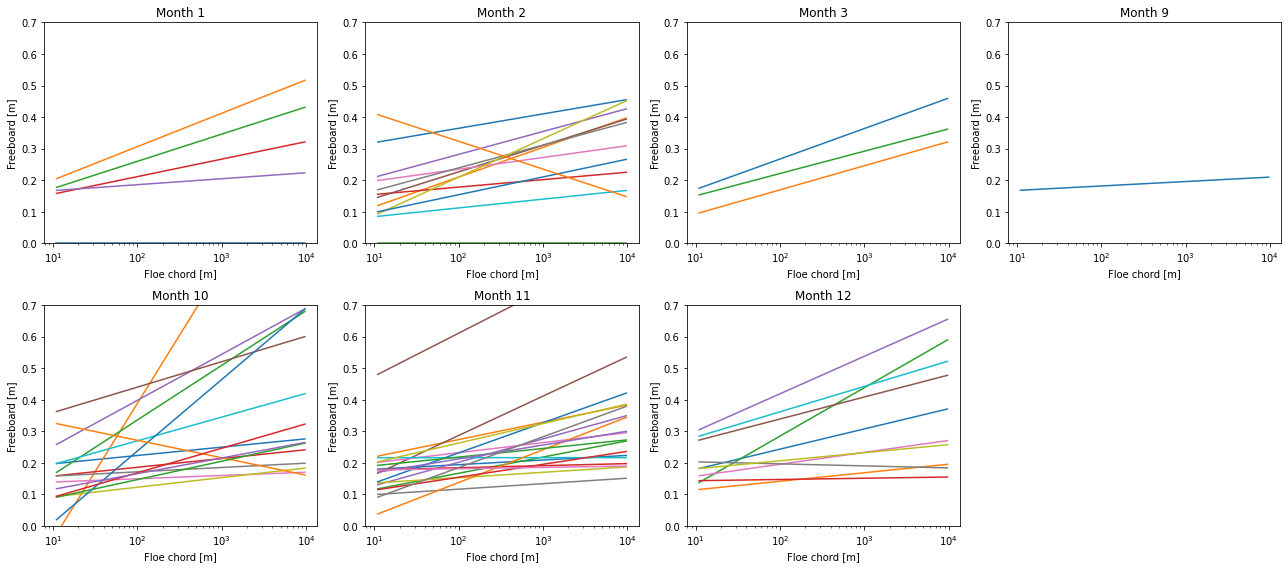

In [172]:
mths_labels = []
mths_unique = np.sort(np.unique(mth_all)) 
mths_unique = mths_unique[np.isnan(mths_unique)==0]
nmonths = len(mths_unique)

# fig, ax = plt.subplots(figsize = (15, 15),nrows=4, ncols=2)

fig = plt.figure(figsize = (18, 8))
for i in range(nmonths):
    mth = mths_unique[i]
    idx = np.where(mth_all == mth)[0]
    ax = fig.add_subplot(2, 4, i+1)
    ax.plot(floe_chord_bin_means,floe_fb_mean_all[:,idx])
    ax.set_xscale("log")
    plt.ylim((0,0.7))
    plt.xlabel("Floe chord [m]")
    plt.ylabel("Freeboard [m]")
    plt.title("Month "+str(int(mth)))

fig.tight_layout()

In [173]:
### TESTING CELL. Not working
do_this = 0

if do_this == 1:
    import cartopy
    import cartopy.crs as ccrs
    import numpy as npy
    import numpy as np
    import matplotlib.pylab as plt

    lon = np.linspace(-80, 80, 25)
    lat = np.linspace(30, 70, 25)
    lon2d, lat2d = np.meshgrid(lon, lat)

    data = np.cos(np.deg2rad(lat2d) * 4) + np.sin(np.deg2rad(lon2d) * 4)
    data_crs = ccrs.PlateCarree()

    projection = ccrs.RotatedPole(pole_longitude=-177.5, pole_latitude=37.5)
    plt.figure(figsize=(6, 3))
    ax = plt.axes(projection=projection)
    ax.set_global()
    ax.coastlines()

    # ...but now using the transform argument
    ax.contourf(lon, lat, data, transform=data_crs)
    plt.show()

    import sys
    sys.exit()

    this_lat = floe_lats_full[floe_months_full==10]*1
    this_lon = floe_lons_full[floe_months_full==10]*1

    lon, lat = npy.meshgrid(npy.arange(-180,180,10),npy.arange(-90,-60,5))

    newproj=ccrs.SouthPolarStereo(central_longitude=80.0)
    pxy = newproj.transform_points(ccrs.PlateCarree(),lon, lat)
    print(npy.shape(pxy))
    px=pxy[:,:,0]
    py=pxy[:,:,1]

    fig_vn = plt.figure(figsize = (18, 9))
    ax_vn = fig_vn.add_subplot(1,1,1,projection=newproj)

    ax_vn.contourf(px,py,px)

    ax_vn.add_feature(cartopy.feature.LAND,zorder=100,alpha=0.7,facecolor="grey")
    ax_vn.gridlines(zorder=10,linewidth=0.25,linestyle="--")
    ax_vn.coastlines(zorder=100)


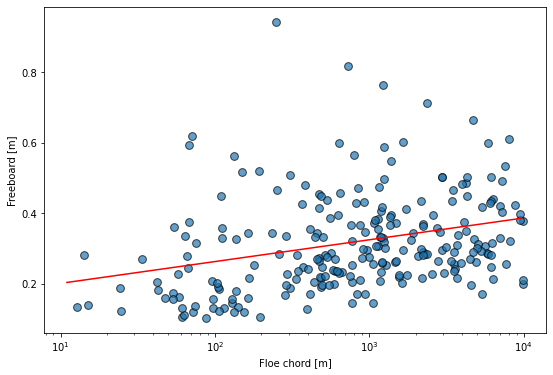

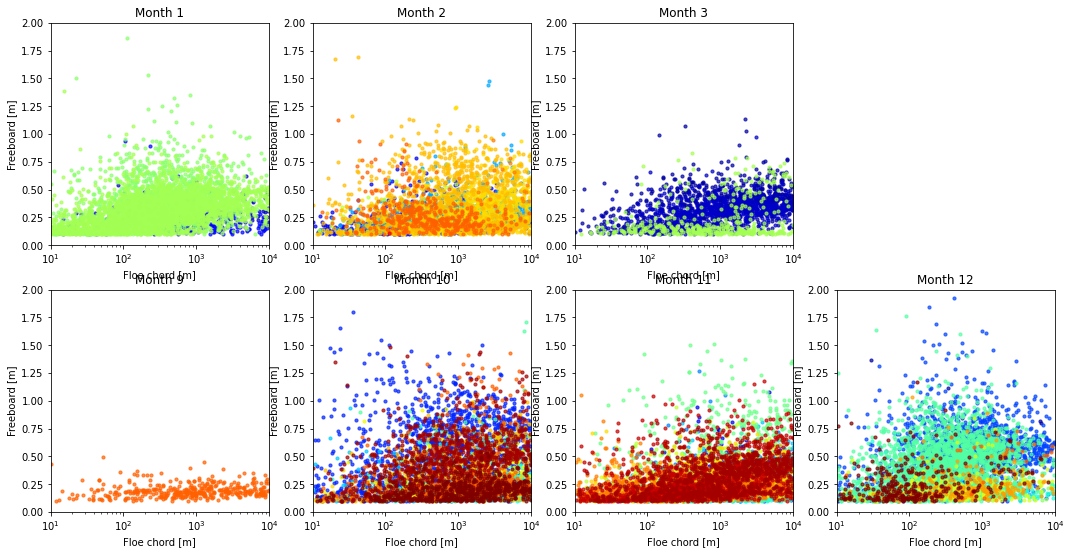

In [182]:
fig, ax = plt.subplots(figsize = (9, 6))
ax.scatter(floe_chord_lengths,floe_fb, s=60, alpha=0.7, edgecolors="k")
ax.plot(floe_chord_bin_means,floe_fb_best_fit,color='r')
ax.set_xscale("log");
plt.xlabel("Floe chord [m]")
plt.ylabel("Freeboard [m]")

jetmap = plt.get_cmap('jet')
jetcols = jetmap(np.linspace(0,1,32))

fig1 = plt.figure(figsize = (18, 9))

mcnt = 1
for mm in range(1,13):
    
    if (mm < 4) | (mm > 8):
        axall = fig1.add_subplot(2,4, mcnt)
        #ax.scatter(floe_chord_lengths_full[floe_months_full==mm],floe_fb_full[floe_months_full==mm], 
        #           s=60, alpha=0.7, edgecolors="k")
        this_cl = floe_chord_lengths_full[floe_months_full==mm]*1
        this_fb = floe_fb_full[floe_months_full==mm]*1
        sub_days = floe_days_full[floe_months_full==mm]*1
        sub_years = floe_years_full[floe_months_full==mm]*1
        
        for dd in range(1,32):
            
            this_color = jetcols[dd,:]
            axall.scatter(this_cl[sub_days==dd],this_fb[sub_days==dd],s=10, alpha=0.7, color=jetcols[dd,:])

        axall.set_xscale("log");

        plt.xlabel("Floe chord [m]")
        plt.ylabel("Freeboard [m]")
        axall.set_title("Month "+str(mm))
        axall.set_ylim([0,2])
        axall.set_xlim([1e1,1e4])
        mcnt = mcnt + 1
        if mm == 3:
            mcnt = mcnt + 1
    

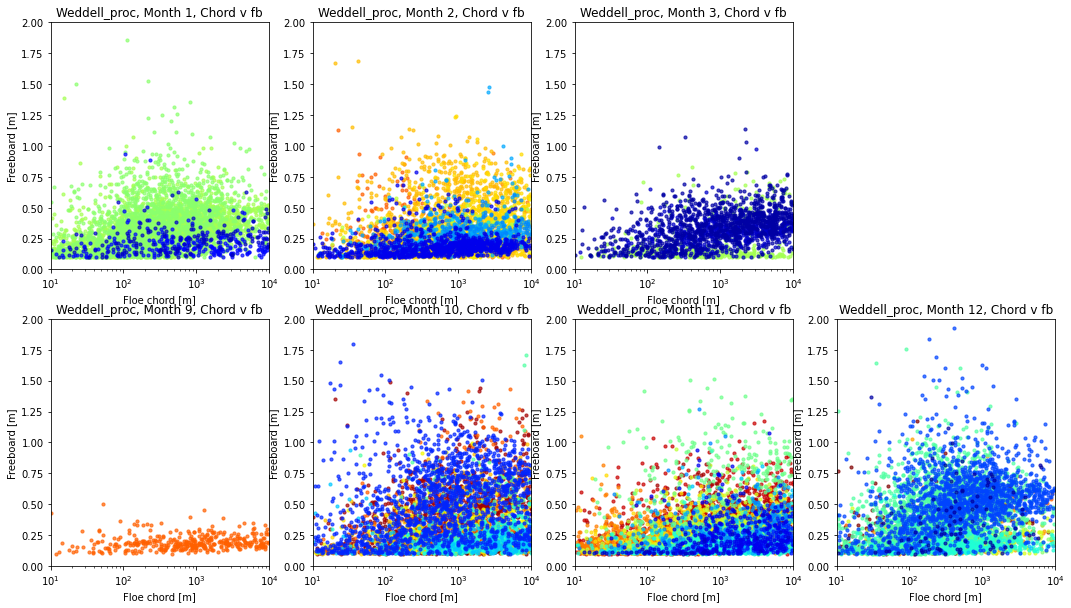

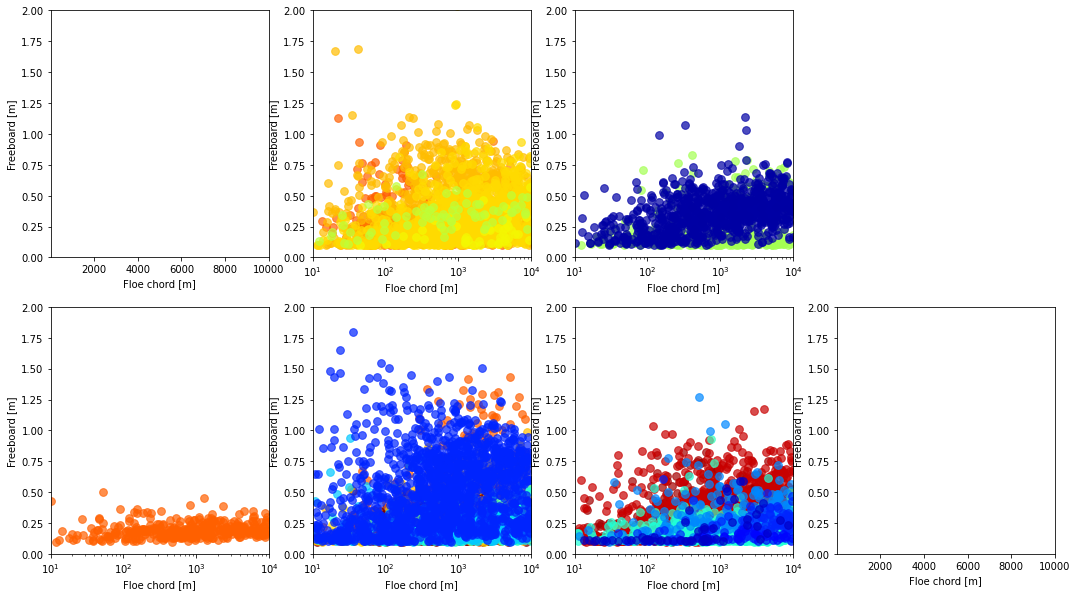

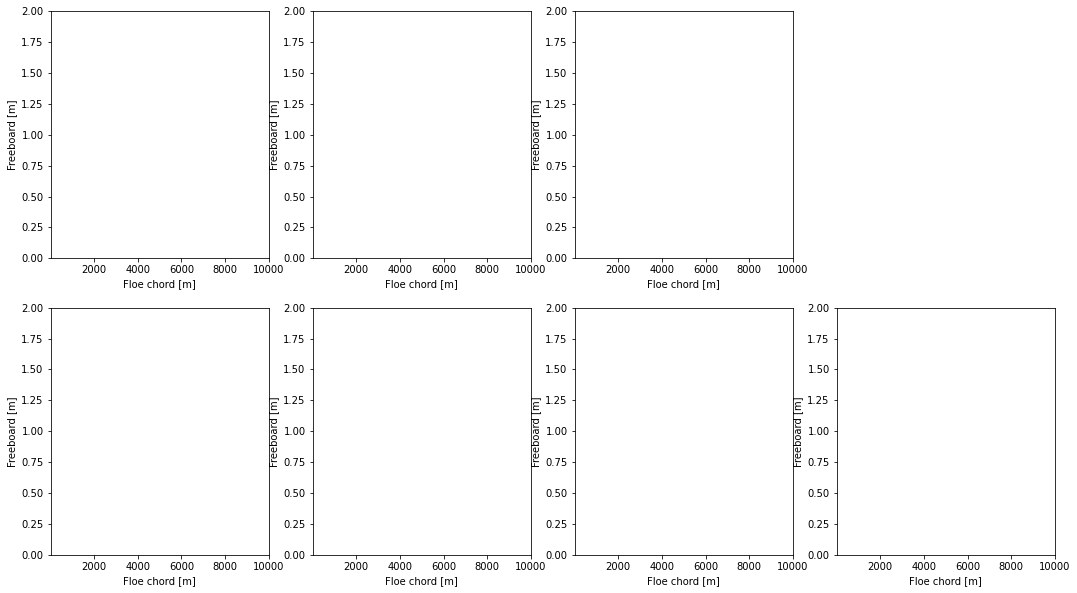

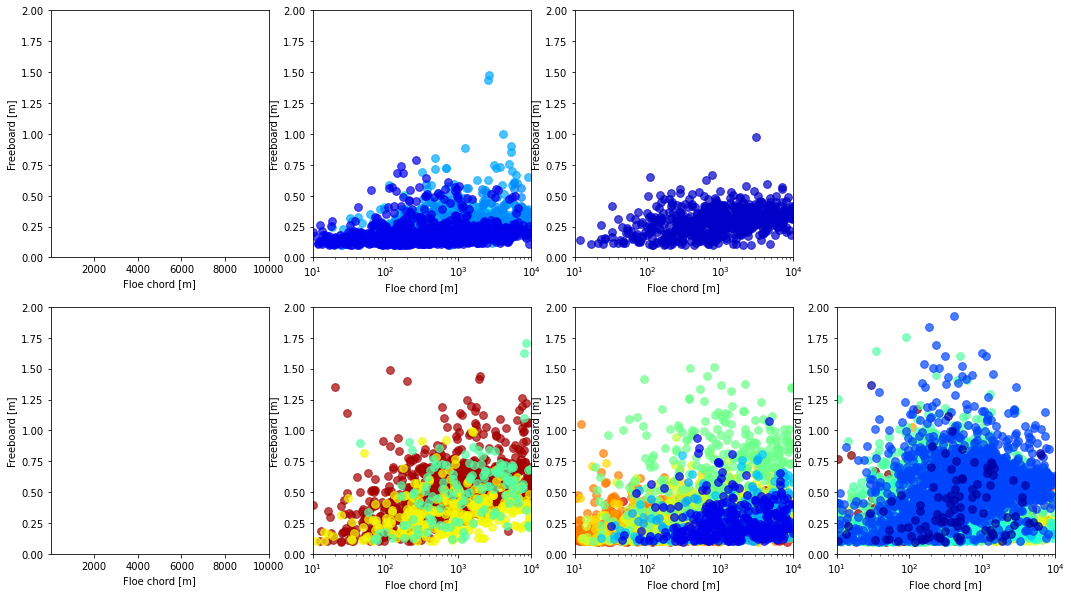

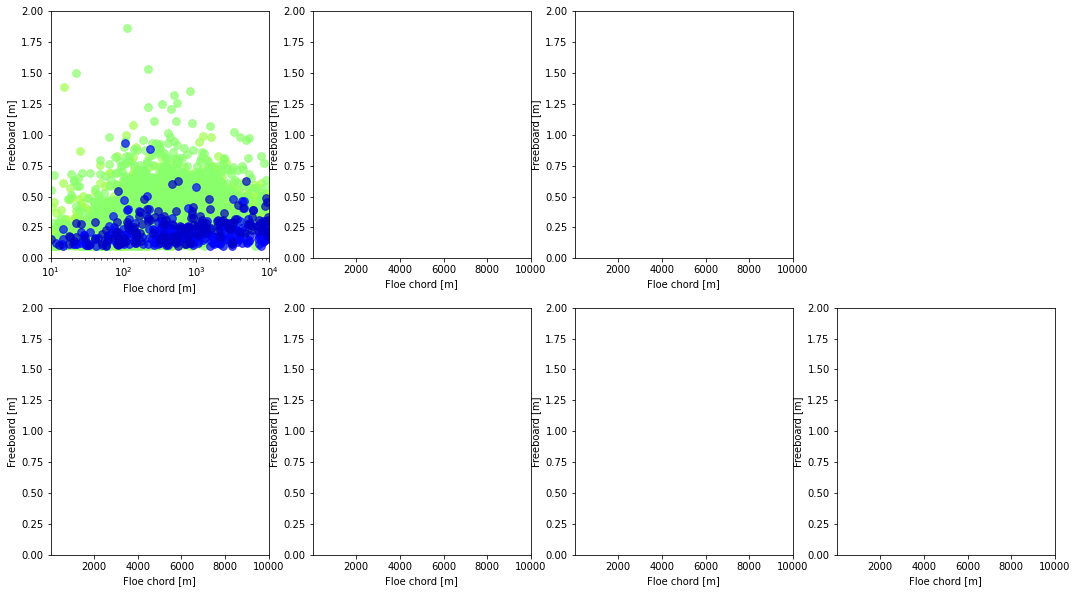

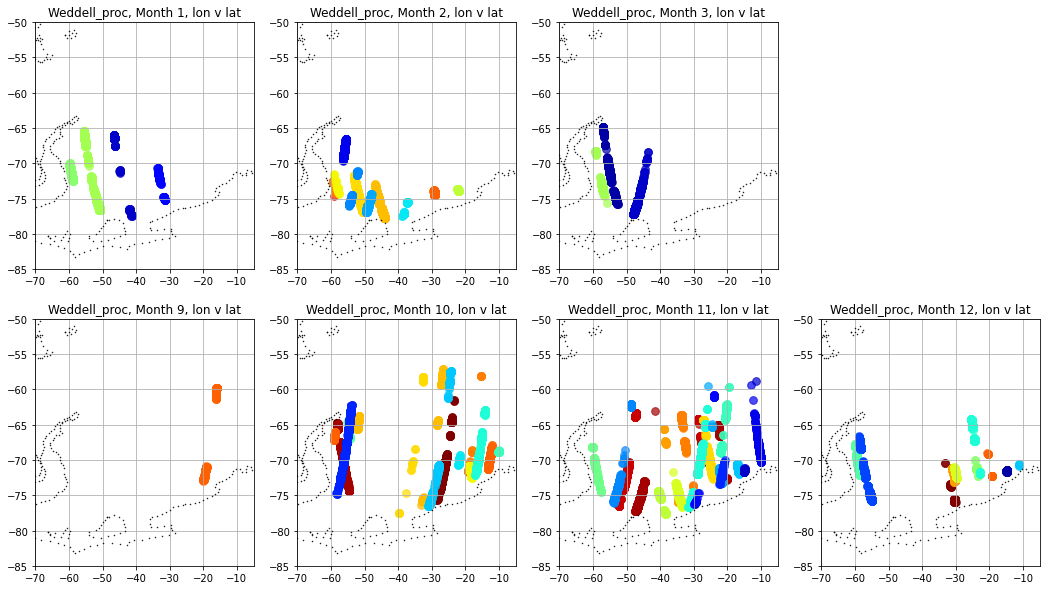

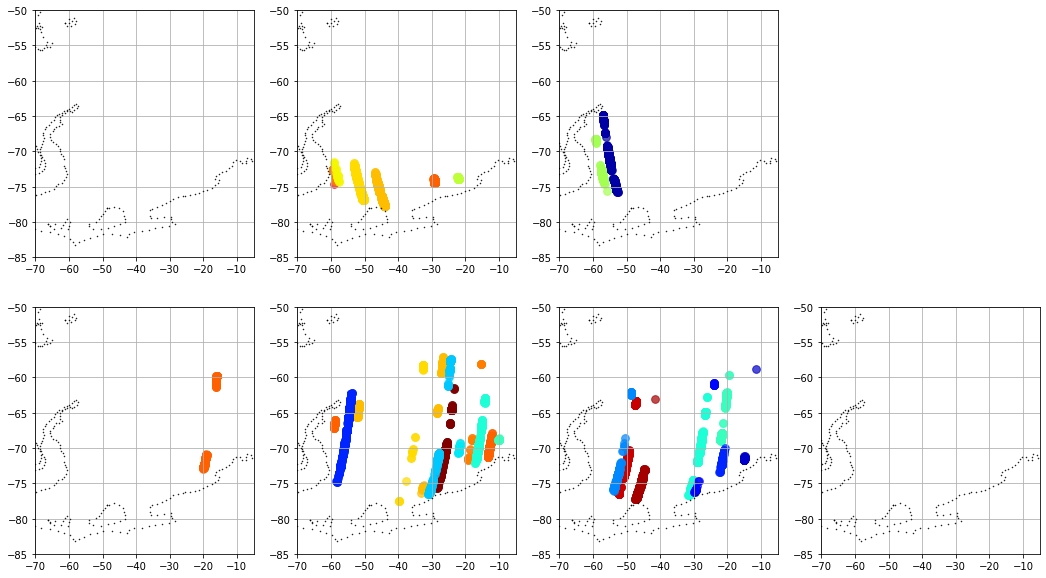

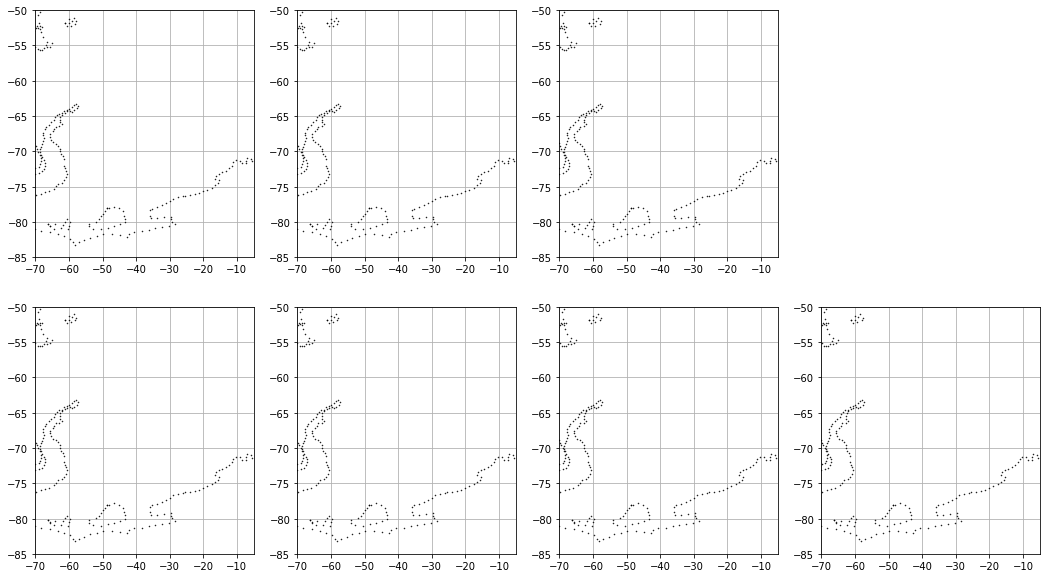

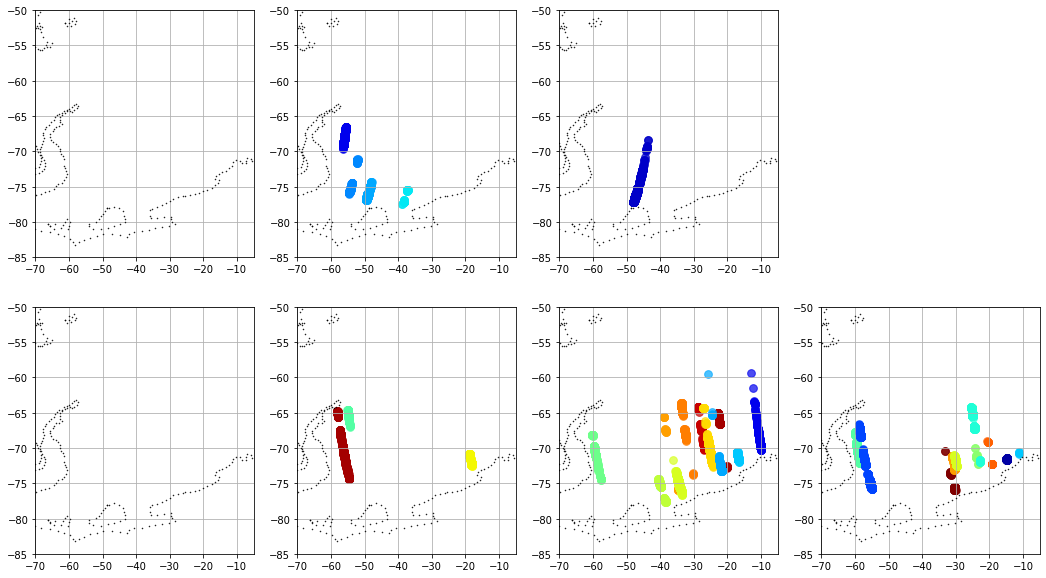

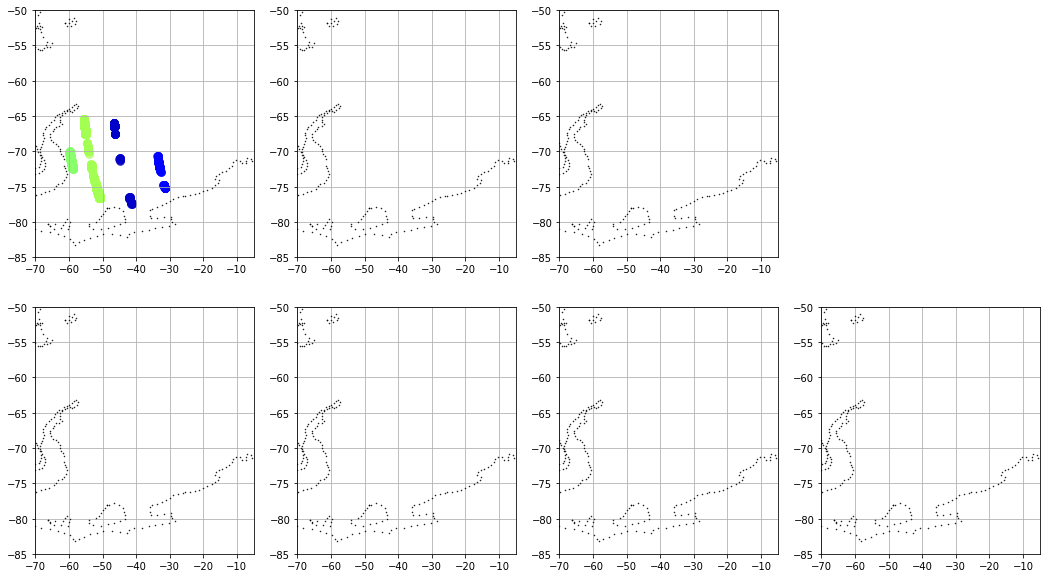

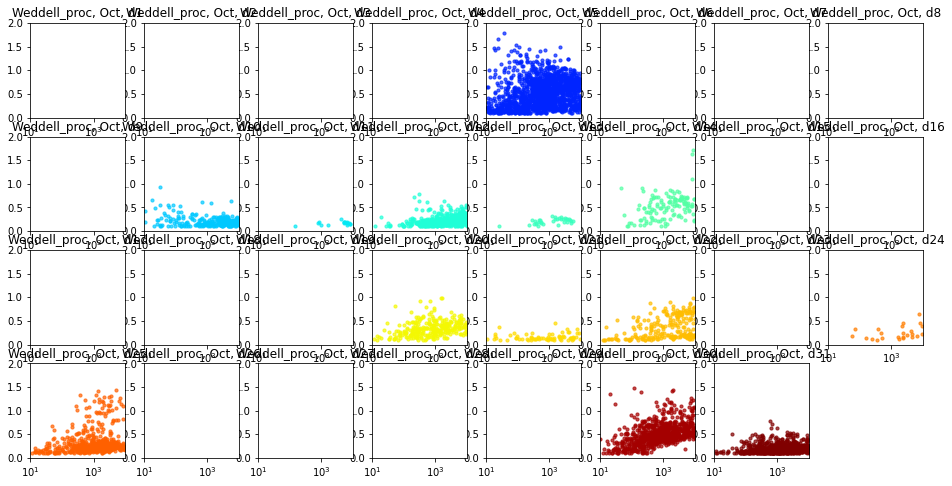

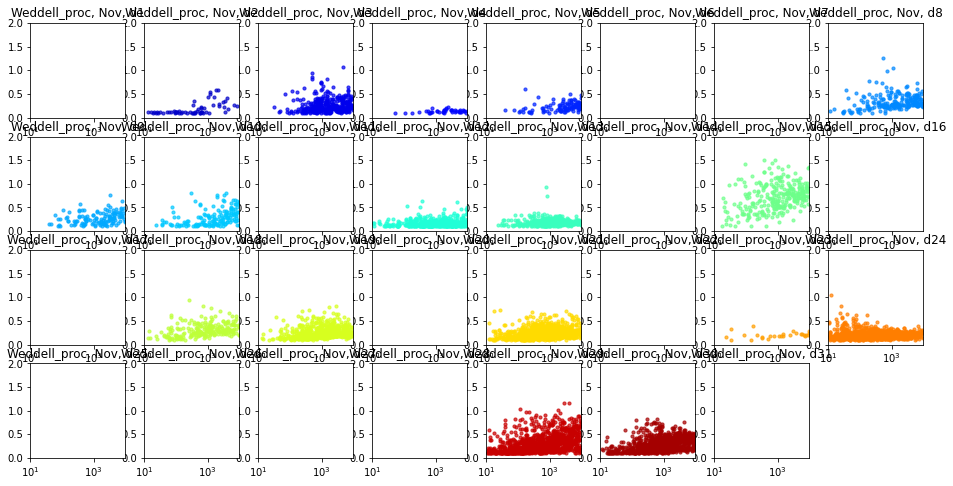

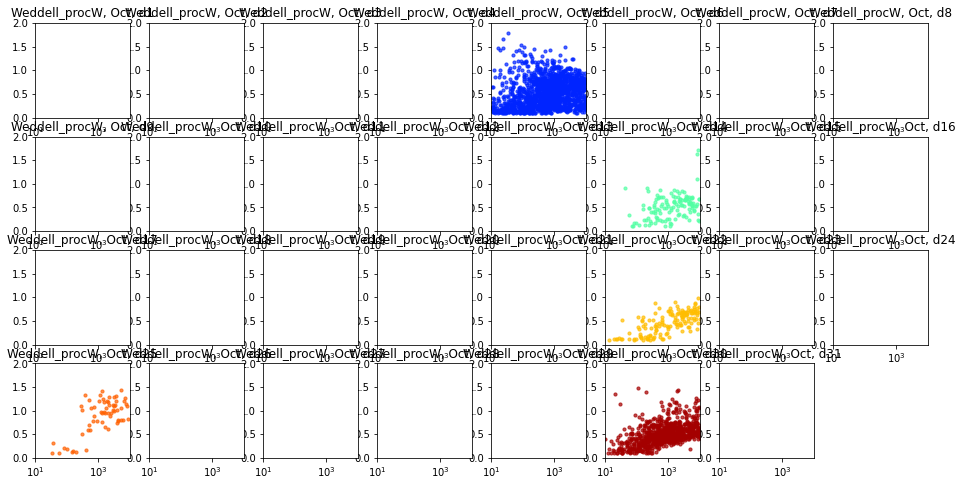

<Figure size 1152x576 with 0 Axes>

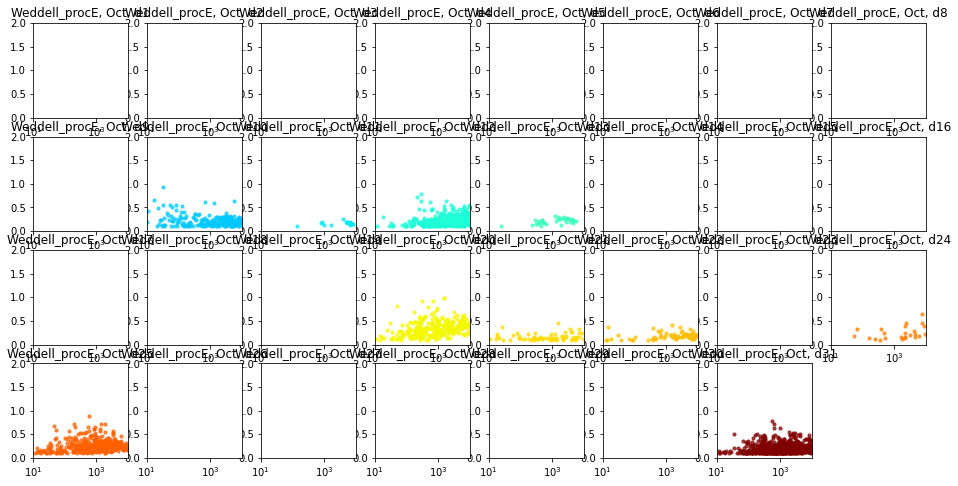

<Figure size 1152x576 with 0 Axes>

In [185]:
fig1 = plt.figure(figsize = (18, 10))
fig2 = plt.figure(figsize = (18, 10))
fig3 = plt.figure(figsize = (18, 10))
fig4 = plt.figure(figsize = (18, 10))
fig5 = plt.figure(figsize = (18, 10))

fig1_m = plt.figure(figsize = (18, 10))
fig2_m = plt.figure(figsize = (18, 10))
fig3_m = plt.figure(figsize = (18, 10))
fig4_m = plt.figure(figsize = (18, 10))
fig5_m = plt.figure(figsize = (18, 10))

fig1_Oct = plt.figure(figsize = (16, 8))
fig1_Nov = plt.figure(figsize = (16, 8))
if 'Weddell' in titstr:
    fig1_Oct_W = plt.figure(figsize = (16, 8))
    fig1_Nov_W = plt.figure(figsize = (16, 8))
    fig1_Oct_E = plt.figure(figsize = (16, 8))
    fig1_Nov_E = plt.figure(figsize = (16, 8))


mcnt = 1
for mm in range(1,13):
    
    if (mm < 4) | (mm > 8):
        axall = fig1.add_subplot(2,4, mcnt)
        ax2019 = fig2.add_subplot(2,4, mcnt)
        ax2020 = fig3.add_subplot(2,4, mcnt)
        ax2021 = fig4.add_subplot(2,4, mcnt)
        ax2022 = fig5.add_subplot(2,4, mcnt)
        
        axall_m = fig1_m.add_subplot(2,4, mcnt)
        ax2019_m = fig2_m.add_subplot(2,4, mcnt)
        ax2020_m = fig3_m.add_subplot(2,4, mcnt)
        ax2021_m = fig4_m.add_subplot(2,4, mcnt)
        ax2022_m = fig5_m.add_subplot(2,4, mcnt)
        
        this_cl = floe_chord_lengths_full[floe_months_full==mm]*1
        this_fb = floe_fb_full[floe_months_full==mm]*1
        this_lat = floe_lats_full[floe_months_full==mm]*1
        this_lon = floe_lons_full[floe_months_full==mm]*1
        sub_days = floe_days_full[floe_months_full==mm]*1
        sub_years = floe_years_full[floe_months_full==mm]*1
        
        if lonlim1 != lonlim2:
            this_lon = np.mod(this_lon,360)
            llim = [lonlim2[0],np.mod(lonlim1[1],360)]
            coast_list_lon = np.mod(coast_list_lon,360)
        else:
            llim = lonlim1
        
        for dd in np.arange(31,0,-1):
            
            this_color = jetcols[dd,:]
            
            if mm == 10:
                axOct = fig1_Oct.add_subplot(4,8, dd)
                axOct.scatter(this_cl[(sub_days==dd)],this_fb[(sub_days==dd)],s=10, alpha=0.7, color=jetcols[dd,:])
                axOct.set_title(titstr+", Oct, d"+str(dd))
                axOct.set_ylim([0,2]); axOct.set_xlim([1e1,1e4])
                axOct.set_xscale("log");
                
                if 'Weddell' in titstr:
                    
                    axOct = fig1_Oct_W.add_subplot(4,8, dd)
                    axOct.scatter(this_cl[(sub_days==dd)&(this_lon<-50)],this_fb[(sub_days==dd)&(this_lon<-50)],s=10, alpha=0.7, color=jetcols[dd,:])
                    axOct.set_title(titstr+"W, Oct, d"+str(dd))
                    axOct.set_ylim([0,2]); axOct.set_xlim([1e1,1e4])
                    axOct.set_xscale("log");

                    axOct = fig1_Oct_E.add_subplot(4,8, dd)
                    axOct.scatter(this_cl[(sub_days==dd)&(this_lon>-50)],this_fb[(sub_days==dd)&(this_lon>-50)],s=10, alpha=0.7, color=jetcols[dd,:])
                    axOct.set_title(titstr+"E, Oct, d"+str(dd))
                    axOct.set_ylim([0,2]); axOct.set_xlim([1e1,1e4])
                    axOct.set_xscale("log");
                    
            if mm == 11:
                axNov = fig1_Nov.add_subplot(4,8, dd)
                axNov.scatter(this_cl[sub_days==dd],this_fb[sub_days==dd],s=10, alpha=0.7, color=jetcols[dd,:])
                axNov.set_title(titstr+", Nov, d"+str(dd))
                axNov.set_ylim([0,2]); axNov.set_xlim([1e1,1e4])
                axNov.set_xscale("log");
            
            
            axall.scatter(this_cl[sub_days==dd],this_fb[sub_days==dd],s=10, alpha=0.7, color=jetcols[dd,:])
            ax2019.scatter(this_cl[(sub_days==dd) & (sub_years==2019)],this_fb[(sub_days==dd) & (sub_years==2019)],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2020.scatter(this_cl[(sub_days==dd) & (sub_years==2020)],this_fb[(sub_days==dd) & (sub_years==2020)],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2021.scatter(this_cl[(sub_days==dd) & (sub_years==2021)],this_fb[(sub_days==dd) & (sub_years==2021)],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2022.scatter(this_cl[(sub_days==dd) & (sub_years==2022)],this_fb[(sub_days==dd) & (sub_years==2022)],s=60, alpha=0.7, color=jetcols[dd,:])

            axall_m.scatter(this_lon[sub_days==dd],this_lat[sub_days==dd],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2019_m.scatter(this_lon[(sub_days==dd) & (sub_years==2019)],this_lat[(sub_days==dd) & (sub_years==2019)],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2020_m.scatter(this_lon[(sub_days==dd) & (sub_years==2020)],this_lat[(sub_days==dd) & (sub_years==2020)],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2021_m.scatter(this_lon[(sub_days==dd) & (sub_years==2021)],this_lat[(sub_days==dd) & (sub_years==2021)],s=60, alpha=0.7, color=jetcols[dd,:])
            ax2022_m.scatter(this_lon[(sub_days==dd) & (sub_years==2022)],this_lat[(sub_days==dd) & (sub_years==2022)],s=60, alpha=0.7, color=jetcols[dd,:])
                            
        if len(this_cl) > 0:
            axall.set_xscale("log");
            axall.set_title(titstr+", Month "+str(mm)+', Chord v fb')
            axall_m.set_title(titstr+", Month "+str(mm)+', lon v lat')
        if len(this_cl[(sub_years==2019)]) > 0:
            ax2019.set_xscale("log");
        if len(this_cl[(sub_years==2020)]) > 0:
            ax2020.set_xscale("log");
        if len(this_cl[(sub_years==2021)]) > 0:
            ax2021.set_xscale("log");
        if len(this_cl[(sub_years==2022)]) > 0:
            ax2022.set_xscale("log");
            
        axall.set_xlabel("Floe chord [m]"); axall.set_ylabel("Freeboard [m]")
        ax2019.set_xlabel("Floe chord [m]"); ax2019.set_ylabel("Freeboard [m]")
        ax2020.set_xlabel("Floe chord [m]"); ax2020.set_ylabel("Freeboard [m]")
        ax2021.set_xlabel("Floe chord [m]"); ax2021.set_ylabel("Freeboard [m]")
        ax2022.set_xlabel("Floe chord [m]"); ax2022.set_ylabel("Freeboard [m]")
        
        axall.set_ylim([0,2]); axall.set_xlim([1e1,1e4])
        ax2019.set_ylim([0,2]); ax2019.set_xlim([1e1,1e4])
        ax2020.set_ylim([0,2]); ax2020.set_xlim([1e1,1e4])
        ax2021.set_ylim([0,2]); ax2021.set_xlim([1e1,1e4])
        ax2022.set_ylim([0,2]); ax2022.set_xlim([1e1,1e4])

        axall_m.set_xlim(llim)
        axall_m.set_ylim(latlim)
        ax2019_m.set_xlim(llim)
        ax2019_m.set_ylim(latlim)
        ax2020_m.set_xlim(llim)
        ax2020_m.set_ylim(latlim)
        ax2021_m.set_xlim(llim)
        ax2021_m.set_ylim(latlim)
        ax2022_m.set_xlim(llim)
        ax2022_m.set_ylim(latlim)
        axall_m.grid()
        ax2019_m.grid()
        ax2020_m.grid()
        ax2021_m.grid()
        ax2022_m.grid()
        
        axall_m.plot(coast_list_lon,coast_list_lat,'k.',ms=1)
        ax2019_m.plot(coast_list_lon,coast_list_lat,'k.',ms=1)
        ax2020_m.plot(coast_list_lon,coast_list_lat,'k.',ms=1)
        ax2021_m.plot(coast_list_lon,coast_list_lat,'k.',ms=1)
        ax2022_m.plot(coast_list_lon,coast_list_lat,'k.',ms=1)
        
        
        mcnt = mcnt + 1
        if mm == 3:
            mcnt = mcnt + 1
    
print('saving...')
fig1.savefig(figdir + titstr + '_chordlength_v_freeboard_allyears_permonth.png',bbox_inches='tight')
fig2.savefig(figdir + titstr + '_chordlength_v_freeboard_2019_permonth.png',bbox_inches='tight')
fig3.savefig(figdir + titstr + '_chordlength_v_freeboard_2020_permonth.png',bbox_inches='tight')
fig4.savefig(figdir + titstr + '_chordlength_v_freeboard_2021_permonth.png',bbox_inches='tight')
fig5.savefig(figdir + titstr + '_chordlength_v_freeboard_2022_permonth.png',bbox_inches='tight')

fig1.savefig(figdir + titstr + '_latlon_allyears_permonth.png',bbox_inches='tight')
fig2.savefig(figdir + titstr + '_latlon_v_freeboard_2019_permonth.png',bbox_inches='tight')
fig3.savefig(figdir + titstr + '_latlon_v_freeboard_2020_permonth.png',bbox_inches='tight')
fig4.savefig(figdir + titstr + '_latlon_v_freeboard_2021_permonth.png',bbox_inches='tight')
fig5.savefig(figdir + titstr + '_latlon_v_freeboard_2022_permonth.png',bbox_inches='tight')

fig1_Oct.savefig(figdir + titstr + '_chordlength_v_freeboard_allyears_October.png',bbox_inches='tight')
fig1_Nov.savefig(figdir + titstr + '_chordlength_v_freeboard_allyears_November.png',bbox_inches='tight')
fig1_Oct_E.savefig(figdir + titstr + '_E_chordlength_v_freeboard_allyears_October.png',bbox_inches='tight')
fig1_Nov_E.savefig(figdir + titstr + '_E_chordlength_v_freeboard_allyears_November.png',bbox_inches='tight')
fig1_Oct_W.savefig(figdir + titstr + '_W_chordlength_v_freeboard_allyears_October.png',bbox_inches='tight')
fig1_Nov_W.savefig(figdir + titstr + '_W_chordlength_v_freeboard_allyears_November.png',bbox_inches='tight')
print('saved')

In [ ]:
import sys
sys.exit()
#### UNDER DEVELOPMENT FROM HERE ON

In [143]:
# # Verifying where the leads are 
# idx_st = 0
# idx_en = len(fb_lat)
# plt.plot(fb_lat[idx_st:idx_en],height_segment_type[idx_st:idx_en])
# # plt.plot(fb_lat[idx_st:idx_en],fb_height[idx_st:idx_en])
# plt.scatter(lead_lat,np.ones(len(lead_lat)))
# plt.xlim((fb_lat[idx_st], fb_lat[idx_en-1]))  


Why are some locations correlated between floe fb and chord length and others not?
(7523, 3)


NameError: name 'axall_l' is not defined

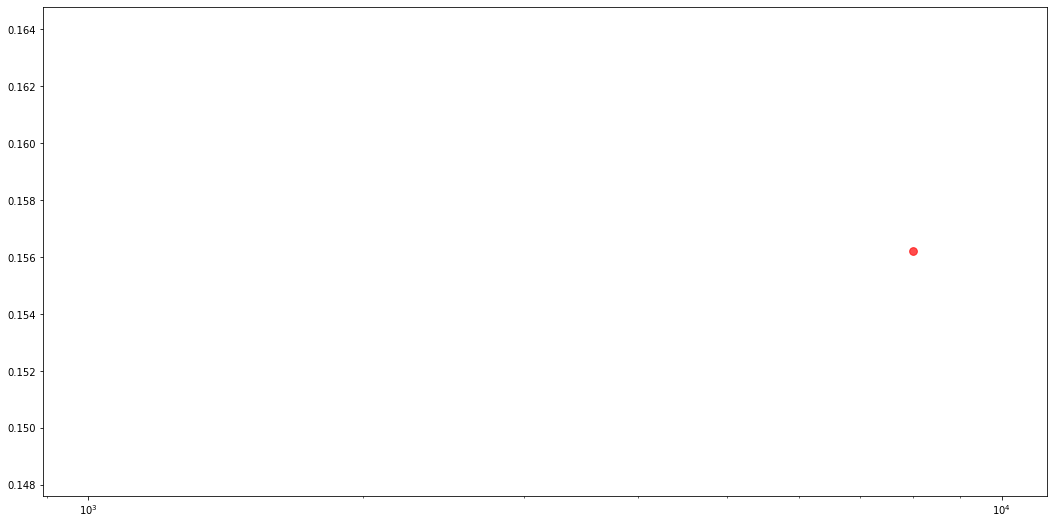

In [144]:
print('Why are some locations correlated between floe fb and chord length and others not?')

fig1 = plt.figure(figsize = (18, 9))
axall = fig1.add_subplot(1,1,1)

mcnt = 1
do_now = 1
#for mm in range(1,13):

correlated_dates = np.zeros([len(floe_years_full),3])
for i in range(0,len(floe_years_full)):
            correlated_dates[i,:] = [floe_years_full[i],floe_months_full[i],floe_days_full[i]]
        
print(np.shape(correlated_dates))
for ii in range(0,10000):#len(sub_days)):
    
    #if (mm < 4) | (mm > 8):
    if do_now == 1:

        yy = correlated_dates[ii,0].astype(int)
        mm = correlated_dates[ii,1].astype(int)
        dd = correlated_dates[ii,2].astype(int)


        this_cl = floe_chord_lengths_full[ii]*1
        this_fb = floe_fb_full[ii]*1
        this_lat = floe_lats_full[ii]*1
        this_lon = floe_lons_full[ii]*1
        sub_days = floe_days_full[ii]*1
        sub_years = floe_years_full[ii]*1
        
        this_color = 'r'#jetcols[int(dd),:]
        plot_now = 1
        if this_fb < 0.2:
            if this_cl > 100:
                plot_now = 0
        axall.scatter(this_cl,this_fb,s=60, alpha=0.7, color=this_color)
            
            # ax.scatter(floe_chord_bin_means,floe_fb_means, s=60, alpha=0.7, edgecolors="k")
                
            
        #ax.plot(floe_chord_bin_means,floe_fb_best_fit,color='r')
        axall.set_xscale("log");
        axall_m.set_xscale("log");
        axall_l.set_xscale("log");

        plt.xlabel("Floe chord [m]")
        plt.ylabel("Freeboard [m]")
        axall.set_title("Month "+str(mm))
        axall.set_ylim([0,2])
        axall.set_xlim([1e1,1e4])
        mcnt = mcnt + 1
        if mm == 3:
            mcnt = mcnt + 1
    